In [1]:
# Base libraries
import time
import datetime
import os
import math

# Scientific librariesz
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc


# Visual libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Helper libraries
import xlrd
import pprint
import base64

# Visual setup

# Pandas options
pd.options.display.max_columns = None

In [2]:
df_consolidado = pd.read_csv('data/2-plata/Consolidado_SIMAT_Depurado.csv',
                             index_col=0,
                             dtype={
                                 'ANO_INF':              'uint16',
                                 'CODIGO_DANE':          'uint64',
                                 'CODIGO_DANE_SEDE':     'uint64',
                                 'TIPO_DOCUMENTO':       'uint8',
                                 'NRO_DOCUMENTO':        'string',
                                 'DIRECCION_RESIDENCIA': 'string',
                                 'RES_DEPTO':            'uint8',
                                 'RES_MUN':              'uint16',
                                 'ESTRATO':              'uint8',
                                 'SISBEN':               'float16',
                                 'GENERO':               'string',
                                 'POB_VICT_CONF':        'uint8',
                                 'PROVIENE_SECTOR_PRIV': 'string',
                                 'PROVIENE_OTR_MUN':     'string',
                                 'TIPO_DISCAPACIDAD':    'uint8',
                                 'CAP_EXC':              'uint8',
                                 'CODIGO_ETNIA':         'uint16',
                                 'CODIGO_JORNADA':       'uint8',
                                 'CARACTER':             'uint8',
                                 'CODIGO_ESPECIALIDAD':  'uint8',
                                 'CODIGO_GRADO':         'int8',
                                 'CODIGO_METODOLOGIA':   'uint8',
                                 'REPITENTE':            'string',
                                 'SIT_ACAD_ANIO_ANT':    'uint8',
                                 'CON_ALUM_ANIO_ANT':    'uint8',
                                 'ZONA_RESI_ALU':        'uint8',
                                 'EDAD':                 'uint8',
                                 'NIVEL':                'uint8',
                                 'DIR_NUM_LOCALIDAD':    'uint8',
                                 'NIVEL_SISBEN':         'uint8'
                             },
                             # Descomentar la linea de abajo si quieren que se convierta
                             # la variable 'FECHA_NACIMIENTO' a datetime
                             # parse_dates=True
                            )

/opt/conda/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_consolidado['INTERCEPTO'] = 1
df_consolidado['INTERCEPTO'] = df_consolidado['INTERCEPTO'].astype('uint8')
df_consolidado['REPITENTE'] = df_consolidado['REPITENTE'].replace({'S': 1, 'N': 0}).astype('uint8')
df_consolidado

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,SIT_ACAD_ANIO_ANT,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO
0,2017,111001000078,111001000078,2,00010803853,CL 69 A 105 F 67,11,1,2,0.010002,2000-01-08,F,9,N,N,99,9,0,6,1,5,10,1,0,1,9,1,17,4,16,1,1
1,2017,111001000078,111001014834,3,05057637,CL 34 SUR 40 A 51,11,1,3,NaN,2012-06-13,F,9,N,N,99,9,0,3,0,0,0,1,0,0,9,1,4,1,16,0,1
2,2017,111001000078,111001014834,3,067289989,KR 54 SUR 50 B 10,11,1,3,NaN,2008-10-07,M,9,N,N,7,9,0,3,0,0,3,1,0,1,9,1,8,2,16,0,1
3,2017,111001000078,111001014834,3,071759788,KR 40 28 A 02 SUR,11,1,3,NaN,2012-08-23,M,9,N,N,99,9,0,3,0,0,0,1,0,0,9,1,4,1,16,0,1
4,2017,111001000078,111001014834,3,089980482,KR 40 28 A 02 SUR,11,1,3,NaN,2013-11-16,F,9,N,N,99,9,0,3,0,0,-1,1,0,0,9,1,3,1,16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4464566,2021,411102000293,411102000293,2,1012336508,KR 105 B 65 81 SUR,11,1,2,54.687500,2005-09-06,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1
4464567,2021,411102000293,411102000293,2,1016713910,KR 99 A 71 39 SUR,11,1,2,61.218750,2005-10-01,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1
4464568,2021,411102000293,411102000293,2,1011090034,CL 62 SUR 93 C 53,11,1,2,58.218750,2005-11-30,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1
4464569,2021,411102000293,411102000293,2,1011092068,CL 61 B SUR 81 D 03,11,1,2,58.250000,2006-02-24,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1


In [4]:
N = df_consolidado.shape[0] # Population size
CI = 0.997  # Confidence interval
Z = norm.ppf((1 + CI) / 2) # CI% significance interval two-tail test on a standard normal distribution 
p = df_consolidado[df_consolidado['REPITENTE'] == 1].shape[0] /  df_consolidado.shape[0] # Approximate proportion of the phenomenon under study to the reference population
q = 1 - p # Proportion of the reference population that does not present the phenomenon under study
d = 0.001 # Error

n = (N * (Z ** 2) * p * q) / ((d ** 2) * (N - 1) + (Z ** 2) * p * q) # Sample size for a finite population
n = int(math.ceil(n))
n 

203853

# Modelo con todas las variables

In [5]:
years = df_consolidado['ANO_INF'].unique().tolist()
options = df_consolidado['REPITENTE'].unique().tolist()

seed = 145
fractions= []
for year in years:
    fraction = df_consolidado[df_consolidado['ANO_INF'] == year]
    n_frac = math.ceil((fraction.shape[0] / df_consolidado.shape[0]) * n)
    n_frac = int(n_frac)
#     print(n_frac)
    fraction = fraction.sample(n=n_frac, random_state=seed)
    fractions.append(fraction)

df_consolidado_frac = pd.concat(fractions)
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,SIT_ACAD_ANIO_ANT,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,0,21.921875,2011-08-05,M,9,N,N,99,9,0,2,0,0,0,1,0,1,9,1,5,1,18,1,1
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,3,0.010002,2002-07-05,M,9,N,N,99,9,0,3,0,0,9,1,0,1,9,1,14,3,11,1,1
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,3,NaN,2009-08-27,M,9,N,N,99,9,0,2,0,0,2,1,0,8,8,1,7,2,6,0,1
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,3,NaN,2008-05-16,F,9,N,N,99,9,0,1,0,0,4,1,0,1,9,1,8,2,15,0,1
71847,2017,111001011011,111001011011,2,1122839699,CL 48 SUR 29 80,11,1,2,25.890625,2006-02-10,M,9,N,N,99,9,0,2,0,0,6,1,0,1,9,1,11,3,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940622,2021,111001025313,111001025313,5,1010215877,KR 19 A 12 45,11,1,2,0.000000,2012-05-28,F,99,S,N,99,9,0,6,0,0,3,1,0,1,9,1,9,2,14,1,1
3743164,2021,111001011053,111001011053,2,1013590836,KR 23 A 16 14 SUR,11,1,3,13.531250,2005-09-02,M,99,N,N,99,9,0,2,0,0,9,1,1,2,9,1,15,3,15,1,1
3959866,2021,111001027391,111001027391,5,1028898686,KR 93 C 61 B 67 SUR,11,1,2,0.000000,2016-10-02,F,99,N,N,99,9,0,3,0,0,-1,1,0,1,9,1,4,1,8,1,1
4082831,2021,111001075329,111001075329,5,1023404127,KR 18 ESTE 60 A 11 SUR,25,754,1,0.000000,2014-08-12,M,99,N,N,99,9,0,2,0,0,1,1,0,1,9,1,6,2,19,1,1


In [6]:
df_consolidado_frac.to_csv('data/2-plata/Muestra_Consolidado_Valeria.csv')

In [6]:
years = df_consolidado['ANO_INF'].unique().tolist()
per_original = df_consolidado[df_consolidado['REPITENTE'] == 1].shape[0] / df_consolidado.shape[0]
per_fraction = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 1].shape[0] / df_consolidado_frac.shape[0]
print(f'original: {per_original} - fraction: {per_fraction} ==> error: {per_original - per_fraction}')
for year in years:
    per_original = df_consolidado[(df_consolidado['ANO_INF'] == year) & (df_consolidado['REPITENTE'] == 1)].shape[0] / df_consolidado[df_consolidado['ANO_INF'] == year].shape[0]  
    per_fraction = df_consolidado_frac[(df_consolidado_frac['ANO_INF'] == year) & (df_consolidado_frac['REPITENTE'] == 1)].shape[0] / df_consolidado_frac[df_consolidado_frac['ANO_INF'] == year].shape[0] 
    print(f'original {year} : {per_original} - fraction {year}: {per_fraction} ==> error: {per_original - per_fraction}')

original: 0.02489124251570271 - fraction: 0.024816537163487952 ==> error: 7.470535221475866e-05
original 2017 : 0.008464341488807913 - fraction 2017: 0.008787510516967374 ==> error: -0.00032316902815946076
original 2018 : 0.01433381376903274 - fraction 2018: 0.014443858724301529 ==> error: -0.00011004495526878953
original 2019 : 0.03739717332957218 - fraction 2019: 0.036681665127089605 ==> error: 0.000715508202482576
original 2020 : 0.03911085777791781 - fraction 2020: 0.039596321214739834 ==> error: -0.0004854634368220215
original 2021 : 0.03837954964348135 - fraction 2021: 0.03758280383939435 ==> error: 0.0007967458040869999


In [7]:
df_consolidado_frac['REPITENTE'].value_counts() / df_consolidado_frac['REPITENTE'].shape[0]

0    0.975183
1    0.024817
Name: REPITENTE, dtype: float64

In [8]:
df_consolidado['REPITENTE'].value_counts() / df_consolidado['REPITENTE'].shape[0]

0    0.975109
1    0.024891
Name: REPITENTE, dtype: float64

In [9]:
# years = df_consolidado['ANO_INF'].unique().tolist()
# options = df_consolidado['REPITENTE'].unique().tolist()
# frac = 0.2
# seed = 145
# fractions= []
# for year in years:
#     for option in options:
#         fraction = df_consolidado[(df_consolidado['ANO_INF'] == year) & (df_consolidado['REPITENTE'] == option)]
#         fraction = fraction.sample(frac=frac, random_state=seed)
#         fractions.append(fraction)

# df_consolidado_frac = pd.concat(fractions)
# df_consolidado_frac

In [10]:
# del df_consolidado

In [11]:
categorias = [
#     'RES_DEPTO', # Muy grande
    'ESTRATO',
    'GENERO',
    'POB_VICT_CONF',
    'PROVIENE_SECTOR_PRIV',
    'PROVIENE_OTR_MUN',
    'TIPO_DISCAPACIDAD',
#     'CAP_EXC', # No hay correlacion
    'CODIGO_ETNIA', # Muy largo
    'CODIGO_JORNADA',
    'CARACTER',
#     'CODIGO_ESPECIALIDAD', # Parecido a CARACTER
#     'CODIGO_GRADO',  # Parecido a NIVEL
    'CODIGO_METODOLOGIA',
    'SIT_ACAD_ANIO_ANT',
#     'CON_ALUM_ANIO_ANT',  # Arroja un probelma enternando el modelo
    'ZONA_RESI_ALU',
    'NIVEL',
    'DIR_NUM_LOCALIDAD',
    'NIVEL_SISBEN'
]

In [12]:
# df_consolidado_frac = df_consolidado_frac.astype({
#     'ANO_INF':              'uint16',
#     'CODIGO_DANE':          'uint64',
#     'CODIGO_DANE_SEDE':     'uint64',
#     'TIPO_DOCUMENTO':       'uint8',
#     'NRO_DOCUMENTO':        'string',
#     'DIRECCION_RESIDENCIA': 'string',
#     'RES_DEPTO':            'uint8',
#     'RES_MUN':              'uint16',
#     'ESTRATO':              'category',
#     'SISBEN':               'float16',
#     'GENERO':               'string',
#     'POB_VICT_CONF':        'category',
#     'PROVIENE_SECTOR_PRIV': 'category',
#     'PROVIENE_OTR_MUN':     'category',
#     'TIPO_DISCAPACIDAD':    'category',
#     'CAP_EXC':              'category',
#     'CODIGO_ETNIA':         'category',
#     'CODIGO_JORNADA':       'category',
#     'CARACTER':             'category',
#     'CODIGO_ESPECIALIDAD':  'uint8',
#     'CODIGO_GRADO':         'category',
#     'CODIGO_METODOLOGIA':   'category',
#     'REPITENTE':            'category',
#     'SIT_ACAD_ANIO_ANT':    'category',
#     'CON_ALUM_ANIO_ANT':    'category',
#     'ZONA_RESI_ALU':        'category',
#     'EDAD':                 'uint8',
#     'NIVEL':                'category',
#     'DIR_NUM_LOCALIDAD':    'category',
#     'NIVEL_SISBEN':         'category'    
# })

In [13]:
df_consolidado_frac = pd.get_dummies(
                                df_consolidado_frac,
                                columns=categorias,
                                prefix=categorias,
                                prefix_sep='_',
                                drop_first=True
                               )
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,SISBEN,FECHA_NACIMIENTO,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,CON_ALUM_ANIO_ANT,EDAD,INTERCEPTO,ESTRATO_1,ESTRATO_2,ESTRATO_3,ESTRATO_4,ESTRATO_5,ESTRATO_6,GENERO_M,POB_VICT_CONF_2,POB_VICT_CONF_3,POB_VICT_CONF_4,POB_VICT_CONF_6,POB_VICT_CONF_9,POB_VICT_CONF_10,POB_VICT_CONF_15,POB_VICT_CONF_17,POB_VICT_CONF_18,POB_VICT_CONF_99,PROVIENE_SECTOR_PRIV_S,PROVIENE_OTR_MUN_S,TIPO_DISCAPACIDAD_3,TIPO_DISCAPACIDAD_4,TIPO_DISCAPACIDAD_6,TIPO_DISCAPACIDAD_7,TIPO_DISCAPACIDAD_8,TIPO_DISCAPACIDAD_9,TIPO_DISCAPACIDAD_10,TIPO_DISCAPACIDAD_11,TIPO_DISCAPACIDAD_12,TIPO_DISCAPACIDAD_13,TIPO_DISCAPACIDAD_14,TIPO_DISCAPACIDAD_15,TIPO_DISCAPACIDAD_17,TIPO_DISCAPACIDAD_18,TIPO_DISCAPACIDAD_19,TIPO_DISCAPACIDAD_99,CAP_EXC_2,CAP_EXC_3,CAP_EXC_4,CAP_EXC_5,CAP_EXC_6,CAP_EXC_7,CAP_EXC_9,CODIGO_ETNIA_1,CODIGO_ETNIA_2,CODIGO_ETNIA_3,CODIGO_ETNIA_4,CODIGO_ETNIA_5,CODIGO_ETNIA_6,CODIGO_ETNIA_8,CODIGO_ETNIA_9,CODIGO_ETNIA_10,CODIGO_ETNIA_12,CODIGO_ETNIA_14,CODIGO_ETNIA_15,CODIGO_ETNIA_16,CODIGO_ETNIA_17,CODIGO_ETNIA_19,CODIGO_ETNIA_20,CODIGO_ETNIA_22,CODIGO_ETNIA_23,CODIGO_ETNIA_25,CODIGO_ETNIA_26,CODIGO_ETNIA_27,CODIGO_ETNIA_28,CODIGO_ETNIA_29,CODIGO_ETNIA_31,CODIGO_ETNIA_33,CODIGO_ETNIA_34,CODIGO_ETNIA_35,CODIGO_ETNIA_36,CODIGO_ETNIA_40,CODIGO_ETNIA_42,CODIGO_ETNIA_43,CODIGO_ETNIA_45,CODIGO_ETNIA_46,CODIGO_ETNIA_47,CODIGO_ETNIA_48,CODIGO_ETNIA_49,CODIGO_ETNIA_50,CODIGO_ETNIA_51,CODIGO_ETNIA_54,CODIGO_ETNIA_57,CODIGO_ETNIA_58,CODIGO_ETNIA_64,CODIGO_ETNIA_65,CODIGO_ETNIA_66,CODIGO_ETNIA_67,CODIGO_ETNIA_72,CODIGO_ETNIA_73,CODIGO_ETNIA_74,CODIGO_ETNIA_75,CODIGO_ETNIA_77,CODIGO_ETNIA_82,CODIGO_ETNIA_83,CODIGO_ETNIA_85,CODIGO_ETNIA_86,CODIGO_ETNIA_95,CODIGO_ETNIA_96,CODIGO_ETNIA_97,CODIGO_ETNIA_98,CODIGO_ETNIA_99,CODIGO_ETNIA_101,CODIGO_ETNIA_102,CODIGO_ETNIA_107,CODIGO_ETNIA_200,CODIGO_ETNIA_400,CODIGO_ETNIA_998,CODIGO_ETNIA_999,CODIGO_JORNADA_2,CODIGO_JORNADA_3,CODIGO_JORNADA_4,CODIGO_JORNADA_5,CODIGO_JORNADA_6,CARACTER_1,CARACTER_2,CODIGO_METODOLOGIA_2,CODIGO_METODOLOGIA_9,CODIGO_METODOLOGIA_10,CODIGO_METODOLOGIA_11,CODIGO_METODOLOGIA_12,CODIGO_METODOLOGIA_20,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8,ZONA_RESI_ALU_2,NIVEL_2,NIVEL_3,NIVEL_4,DIR_NUM_LOCALIDAD_2,DIR_NUM_LOCALIDAD_3,DIR_NUM_LOCALIDAD_4,DIR_NUM_LOCALIDAD_5,DIR_NUM_LOCALIDAD_6,DIR_NUM_LOCALIDAD_7,DIR_NUM_LOCALIDAD_8,DIR_NUM_LOCALIDAD_9,DIR_NUM_LOCALIDAD_10,DIR_NUM_LOCALIDAD_11,DIR_NUM_LOCALIDAD_12,DIR_NUM_LOCALIDAD_13,DIR_NUM_LOCALIDAD_14,DIR_NUM_LOCALIDAD_15,DIR_NUM_LOCALIDAD_16,DIR_NUM_LOCALIDAD_17,DIR_NUM_LOCALIDAD_18,DIR_NUM_LOCALIDAD_19,DIR_NUM_LOCALIDAD_20,NIVEL_SISBEN_1,NIVEL_SISBEN_2,NIVEL_SISBEN_3
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,21.921875,2011-08-05,0,0,0,9,5,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,0.010002,2002-07-05,0,9,0,9,14,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,NaN,2009-08-27,0,2,0,8,7,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,NaN,2

In [14]:
# df_consolidado_frac.columns[15:].tolist()

In [22]:
model_variables = df_consolidado_frac.columns[14:].tolist()
intercepto_idx = model_variables.index('INTERCEPTO')
model_variables_first = model_variables[0]
model_variables[intercepto_idx] = model_variables_first
model_variables[0] = 'INTERCEPTO'
# model_variables = model_variables[:model_variables.index('NIVEL_SISBEN_1')]
model_variables

['INTERCEPTO',
 'EDAD',
 'ESTRATO_1',
 'ESTRATO_2',
 'ESTRATO_3',
 'ESTRATO_4',
 'ESTRATO_5',
 'ESTRATO_6',
 'GENERO_M',
 'POB_VICT_CONF_2',
 'POB_VICT_CONF_3',
 'POB_VICT_CONF_4',
 'POB_VICT_CONF_6',
 'POB_VICT_CONF_9',
 'POB_VICT_CONF_10',
 'POB_VICT_CONF_15',
 'POB_VICT_CONF_17',
 'POB_VICT_CONF_18',
 'POB_VICT_CONF_99',
 'PROVIENE_SECTOR_PRIV_S',
 'PROVIENE_OTR_MUN_S',
 'TIPO_DISCAPACIDAD_3',
 'TIPO_DISCAPACIDAD_4',
 'TIPO_DISCAPACIDAD_6',
 'TIPO_DISCAPACIDAD_7',
 'TIPO_DISCAPACIDAD_8',
 'TIPO_DISCAPACIDAD_9',
 'TIPO_DISCAPACIDAD_10',
 'TIPO_DISCAPACIDAD_11',
 'TIPO_DISCAPACIDAD_12',
 'TIPO_DISCAPACIDAD_13',
 'TIPO_DISCAPACIDAD_14',
 'TIPO_DISCAPACIDAD_15',
 'TIPO_DISCAPACIDAD_17',
 'TIPO_DISCAPACIDAD_18',
 'TIPO_DISCAPACIDAD_19',
 'TIPO_DISCAPACIDAD_99',
 'CAP_EXC_2',
 'CAP_EXC_3',
 'CAP_EXC_4',
 'CAP_EXC_5',
 'CAP_EXC_6',
 'CAP_EXC_7',
 'CAP_EXC_9',
 'CODIGO_ETNIA_1',
 'CODIGO_ETNIA_2',
 'CODIGO_ETNIA_3',
 'CODIGO_ETNIA_4',
 'CODIGO_ETNIA_5',
 'CODIGO_ETNIA_6',
 'CODIGO_ETNIA_8',

In [23]:
model = sm.GLM(df_consolidado_frac['REPITENTE'], df_consolidado_frac[model_variables], family=sm.families.Binomial())

In [24]:
model_res = model.fit()

In [25]:
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              REPITENTE   No. Observations:               203856
Model:                            GLM   Df Residuals:                   203704
Model Family:                Binomial   Df Model:                          151
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18354.
Date:                Tue, 21 Jun 2022   Deviance:                       36708.
Time:                        00:20:35   Pearson chi2:                 2.18e+05
No. Iterations:                    25   Pseudo R-squ. (CS):            0.05105
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
INTERCEPTO               -28.9457    2.4e+05     -0.000      1.000   -4.71e+05     4.7e+05
EDAD                       0.0807      0.005     15.525      0.000       0.070       0.091
ESTRATO_1                 -0.0860      0.062     -1.382      0.167      -0.208       0.036
ESTRATO_2                 -0.1090      0.055     -1.980      0.048      -0.217      -0.001
ESTRATO_3                 -0.2483      0.067     -3.699      0.000      -0.380      -0.117
ESTRATO_4                 -0.5915      0.220     -2.694      0.007      -1.022      -0.161
ESTRATO_5                 -0.1750      0.404     -0.433      0.665      -0.967       0.617
ESTRATO_6                 -0.9322      0.732     -1.273      0.203      -2.367       0.503
GENERO_M                   0.1930      0.032      6.063      0.000       0.131       0.255
POB_VICT_CONF_2          -22.7733   5.52e+04     -0.000      1.000   -1.08e+05    1.08e+05
POB_VICT_CONF_3           -0.6108      0.818     -0.747      0.455      -2.214       0.992
POB_VICT_CONF_4           -0.3960      1.097     -0.361      0.718      -2.545       1.753
POB_VICT_CONF_6          -22.2169   2.52e+05  -8.83e-05      1.000   -4.93e+05    4.93e+05
POB_VICT_CONF_9           -0.7745      0.088     -8.784      0.000      -0.947      -0.602
POB_VICT_CONF_10          -0.1131      0.661     -0.171      0.864      -1.408       1.182
POB_VICT_CONF_15         -20.2512   2.51e+05  -8.05e-05      1.000   -4.93e+05    4.93e+05
POB_VICT_CONF_17         -22.1165   8.92e+04     -0.000      1.000   -1.75e+05    1.75e+05
POB_VICT_CONF_18         -22.1125   4.96e+04     -0.000      1.000   -9.72e+04    9.72e+04
POB_VICT_CONF_99           0.1912      0.083      2.300      0.021       0.028       0.354
PROVIENE_SECTOR_PRIV_S     0.1019      0.060      1.697      0.090      -0.016       0.220
PROVIENE_OTR_MUN_S        -0.2150      0.146     -1.475      0.140      -0.501       0.071
TIPO_DISCAPACIDAD_3       19.9076    2.4e+05   8.29e-05      1.000    -4.7e+05    4.71e+05
TIPO_DISCAPACIDAD_4       -1.3704   2.45e+05  -5.59e-06      1.000    -4.8e+05     4.8e+05
TIPO_DISCAPACIDAD_6       -1.0104   3.47e+05  -2.91e-06      1.000   -6.81e+05    6.81e+05
TIPO_DISCAPACIDAD_7       21.8038    2.4e+05   9.08e-05      1.000    -4.7e+05    4.71e+05
TIPO_DISCAPACIDAD_8       21.2958    2.4e+05   8.87e-05      1.000    -4.7e+05    4.71e+05
TIPO_DISCAPACIDAD_9        0.6546   2.73e+05    2.4e-06      1.000   -5.36e+05    5.36e+05
TIPO_DISCAPACIDAD_10      20.4252    2.4e+05   8.51e-05      1.000    -4.7e+05    4.71e+05
TIPO_DISCAPACIDAD_11      -1.4018   2.43e+05  -5.78e-06      1.000   -4.75e+05    4.75e+05
TIPO_DISCAPACIDAD_12      20.5816    2.4e+05   8.57e-05      1.000    -4.7e+05    4.71e+05
TIPO_DISCAPACIDAD_13      20.1450    2.4e+05   8.39e-05      1.000    -4.7e+05  

In [31]:
np.exp(-18354)

0.0

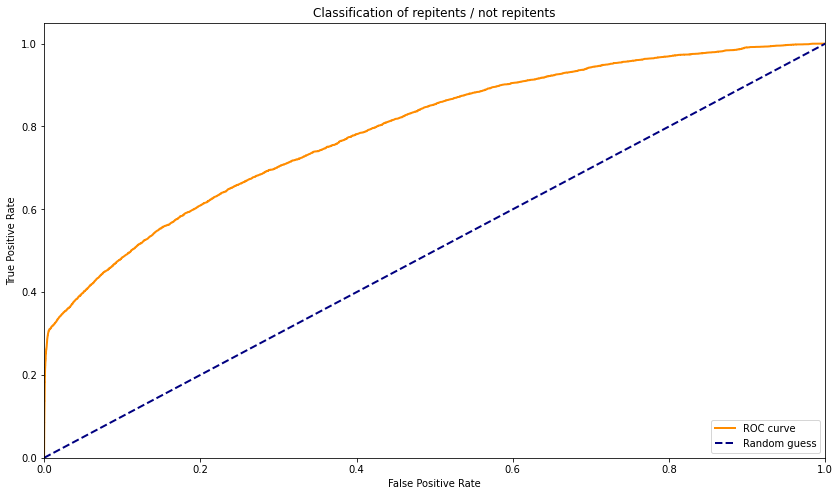

In [26]:
predict_p = model_res.predict(df_consolidado_frac[model_variables])
roc_p = roc_curve(df_consolidado_frac['REPITENTE'], predict_p)
plt.figure(figsize=(14,8))
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of repitents / not repitents')
plt.legend(loc='lower right')
plt.show()

In [20]:
# model = sm.Logit(df_consolidado_frac['REPITENTE'], df_consolidado_frac[model_variables])
# model_res = model.fit()
# model_res.summary()

# Modelo Con Variables Significativas

In [5]:
years = df_consolidado['ANO_INF'].unique().tolist()
options = df_consolidado['REPITENTE'].unique().tolist()

seed = 145
fractions= []
for year in years:
    fraction = df_consolidado[df_consolidado['ANO_INF'] == year]
    n_frac = math.ceil((fraction.shape[0] / df_consolidado.shape[0]) * n)
    n_frac = int(n_frac)
#     print(n_frac)
    fraction = fraction.sample(n=n_frac, random_state=seed)
    fractions.append(fraction)

df_consolidado_frac = pd.concat(fractions)
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,SIT_ACAD_ANIO_ANT,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,0,21.921875,2011-08-05,M,9,N,N,99,9,0,2,0,0,0,1,0,1,9,1,5,1,18,1,1
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,3,0.010002,2002-07-05,M,9,N,N,99,9,0,3,0,0,9,1,0,1,9,1,14,3,11,1,1
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,3,NaN,2009-08-27,M,9,N,N,99,9,0,2,0,0,2,1,0,8,8,1,7,2,6,0,1
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,3,NaN,2008-05-16,F,9,N,N,99,9,0,1,0,0,4,1,0,1,9,1,8,2,15,0,1
71847,2017,111001011011,111001011011,2,1122839699,CL 48 SUR 29 80,11,1,2,25.890625,2006-02-10,M,9,N,N,99,9,0,2,0,0,6,1,0,1,9,1,11,3,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940622,2021,111001025313,111001025313,5,1010215877,KR 19 A 12 45,11,1,2,0.000000,2012-05-28,F,99,S,N,99,9,0,6,0,0,3,1,0,1,9,1,9,2,14,1,1
3743164,2021,111001011053,111001011053,2,1013590836,KR 23 A 16 14 SUR,11,1,3,13.531250,2005-09-02,M,99,N,N,99,9,0,2,0,0,9,1,1,2,9,1,15,3,15,1,1
3959866,2021,111001027391,111001027391,5,1028898686,KR 93 C 61 B 67 SUR,11,1,2,0.000000,2016-10-02,F,99,N,N,99,9,0,3,0,0,-1,1,0,1,9,1,4,1,8,1,1
4082831,2021,111001075329,111001075329,5,1023404127,KR 18 ESTE 60 A 11 SUR,25,754,1,0.000000,2014-08-12,M,99,N,N,99,9,0,2,0,0,1,1,0,1,9,1,6,2,19,1,1


In [6]:
years = df_consolidado['ANO_INF'].unique().tolist()
per_original = df_consolidado[df_consolidado['REPITENTE'] == 1].shape[0] / df_consolidado.shape[0]
per_fraction = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 1].shape[0] / df_consolidado_frac.shape[0]
print(f'original: {per_original} - fraction: {per_fraction} ==> error: {per_original - per_fraction}')
for year in years:
    per_original = df_consolidado[(df_consolidado['ANO_INF'] == year) & (df_consolidado['REPITENTE'] == 1)].shape[0] / df_consolidado[df_consolidado['ANO_INF'] == year].shape[0]  
    per_fraction = df_consolidado_frac[(df_consolidado_frac['ANO_INF'] == year) & (df_consolidado_frac['REPITENTE'] == 1)].shape[0] / df_consolidado_frac[df_consolidado_frac['ANO_INF'] == year].shape[0] 
    print(f'original {year} : {per_original} - fraction {year}: {per_fraction} ==> error: {per_original - per_fraction}')

original: 0.02489124251570271 - fraction: 0.024816537163487952 ==> error: 7.470535221475866e-05
original 2017 : 0.008464341488807913 - fraction 2017: 0.008787510516967374 ==> error: -0.00032316902815946076
original 2018 : 0.01433381376903274 - fraction 2018: 0.014443858724301529 ==> error: -0.00011004495526878953
original 2019 : 0.03739717332957218 - fraction 2019: 0.036681665127089605 ==> error: 0.000715508202482576
original 2020 : 0.03911085777791781 - fraction 2020: 0.039596321214739834 ==> error: -0.0004854634368220215
original 2021 : 0.03837954964348135 - fraction 2021: 0.03758280383939435 ==> error: 0.0007967458040869999


In [7]:
categorias = [
#     'RES_DEPTO', # Muy grande
    'ESTRATO',
    'GENERO',
    'POB_VICT_CONF',
#     'PROVIENE_SECTOR_PRIV',
#     'PROVIENE_OTR_MUN',
#     'TIPO_DISCAPACIDAD',
#     'CAP_EXC', # No hay correlacion
    'CODIGO_ETNIA', # Muy largo
    'CODIGO_JORNADA',
#     'CARACTER',
#     'CODIGO_ESPECIALIDAD', # Parecido a CARACTER
#     'CODIGO_GRADO',  # Parecido a NIVEL
    'CODIGO_METODOLOGIA',
    'SIT_ACAD_ANIO_ANT',
#     'CON_ALUM_ANIO_ANT',  # Arroja un probelma enternando el modelo
    'ZONA_RESI_ALU',
    'NIVEL',
    'DIR_NUM_LOCALIDAD',
#     'NIVEL_SISBEN'
]

In [8]:
df_consolidado_frac = pd.get_dummies(
                                df_consolidado_frac,
                                columns=categorias,
                                prefix=categorias,
                                prefix_sep='_',
                                drop_first=True
                               )
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,SISBEN,FECHA_NACIMIENTO,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,CON_ALUM_ANIO_ANT,EDAD,NIVEL_SISBEN,INTERCEPTO,ESTRATO_1,ESTRATO_2,ESTRATO_3,ESTRATO_4,ESTRATO_5,ESTRATO_6,GENERO_M,POB_VICT_CONF_2,POB_VICT_CONF_3,POB_VICT_CONF_4,POB_VICT_CONF_6,POB_VICT_CONF_9,POB_VICT_CONF_10,POB_VICT_CONF_15,POB_VICT_CONF_17,POB_VICT_CONF_18,POB_VICT_CONF_99,CODIGO_ETNIA_1,CODIGO_ETNIA_2,CODIGO_ETNIA_3,CODIGO_ETNIA_4,CODIGO_ETNIA_5,CODIGO_ETNIA_6,CODIGO_ETNIA_8,CODIGO_ETNIA_9,CODIGO_ETNIA_10,CODIGO_ETNIA_12,CODIGO_ETNIA_14,CODIGO_ETNIA_15,CODIGO_ETNIA_16,CODIGO_ETNIA_17,CODIGO_ETNIA_19,CODIGO_ETNIA_20,CODIGO_ETNIA_22,CODIGO_ETNIA_23,CODIGO_ETNIA_25,CODIGO_ETNIA_26,CODIGO_ETNIA_27,CODIGO_ETNIA_28,CODIGO_ETNIA_29,CODIGO_ETNIA_31,CODIGO_ETNIA_33,CODIGO_ETNIA_34,CODIGO_ETNIA_35,CODIGO_ETNIA_36,CODIGO_ETNIA_40,CODIGO_ETNIA_42,CODIGO_ETNIA_43,CODIGO_ETNIA_45,CODIGO_ETNIA_46,CODIGO_ETNIA_47,CODIGO_ETNIA_48,CODIGO_ETNIA_49,CODIGO_ETNIA_50,CODIGO_ETNIA_51,CODIGO_ETNIA_54,CODIGO_ETNIA_57,CODIGO_ETNIA_58,CODIGO_ETNIA_64,CODIGO_ETNIA_65,CODIGO_ETNIA_66,CODIGO_ETNIA_67,CODIGO_ETNIA_72,CODIGO_ETNIA_73,CODIGO_ETNIA_74,CODIGO_ETNIA_75,CODIGO_ETNIA_77,CODIGO_ETNIA_82,CODIGO_ETNIA_83,CODIGO_ETNIA_85,CODIGO_ETNIA_86,CODIGO_ETNIA_95,CODIGO_ETNIA_96,CODIGO_ETNIA_97,CODIGO_ETNIA_98,CODIGO_ETNIA_99,CODIGO_ETNIA_101,CODIGO_ETNIA_102,CODIGO_ETNIA_107,CODIGO_ETNIA_200,CODIGO_ETNIA_400,CODIGO_ETNIA_998,CODIGO_ETNIA_999,CODIGO_JORNADA_2,CODIGO_JORNADA_3,CODIGO_JORNADA_4,CODIGO_JORNADA_5,CODIGO_JORNADA_6,CODIGO_METODOLOGIA_2,CODIGO_METODOLOGIA_9,CODIGO_METODOLOGIA_10,CODIGO_METODOLOGIA_11,CODIGO_METODOLOGIA_12,CODIGO_METODOLOGIA_20,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8,ZONA_RESI_ALU_2,NIVEL_2,NIVEL_3,NIVEL_4,DIR_NUM_LOCALIDAD_2,DIR_NUM_LOCALIDAD_3,DIR_NUM_LOCALIDAD_4,DIR_NUM_LOCALIDAD_5,DIR_NUM_LOCALIDAD_6,DIR_NUM_LOCALIDAD_7,DIR_NUM_LOCALIDAD_8,DIR_NUM_LOCALIDAD_9,DIR_NUM_LOCALIDAD_10,DIR_NUM_LOCALIDAD_11,DIR_NUM_LOCALIDAD_12,DIR_NUM_LOCALIDAD_13,DIR_NUM_LOCALIDAD_14,DIR_NUM_LOCALIDAD_15,DIR_NUM_LOCALIDAD_16,DIR_NUM_LOCALIDAD_17,DIR_NUM_LOCALIDAD_18,DIR_NUM_LOCALIDAD_19,DIR_NUM_LOCALIDAD_20
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,21.921875,2011-08-05,N,N,99,9,0,0,0,0,9,5,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,0.010002,2002-07-05,N,N,99,9,0,0,9,0,9,14,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,NaN,2009-08-27,N,N,99,9,0,0,2,0,8,7,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,NaN,2008-05-16,N,N,99,9,0,0,4,0,9,8,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
71847,2017,111001011011,111001011011,2,1122839699,CL 48 SUR 29 80,11,1,25.890625,2006-02-10,N,N,99,9,0,0,6,0,9,11,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

In [9]:
# df_consolidado_frac.columns[15:].tolist()

In [10]:
model_variables = df_consolidado_frac.columns[21:].tolist()
intercepto_idx = model_variables.index('INTERCEPTO')
model_variables_first = model_variables[0]
model_variables[intercepto_idx] = model_variables_first
model_variables[0] = 'INTERCEPTO'
# model_variables = model_variables[:model_variables.index('NIVEL_SISBEN_1')]
model_variables.append('EDAD')
model_variables

['INTERCEPTO',
 'ESTRATO_1',
 'ESTRATO_2',
 'ESTRATO_3',
 'ESTRATO_4',
 'ESTRATO_5',
 'ESTRATO_6',
 'GENERO_M',
 'POB_VICT_CONF_2',
 'POB_VICT_CONF_3',
 'POB_VICT_CONF_4',
 'POB_VICT_CONF_6',
 'POB_VICT_CONF_9',
 'POB_VICT_CONF_10',
 'POB_VICT_CONF_15',
 'POB_VICT_CONF_17',
 'POB_VICT_CONF_18',
 'POB_VICT_CONF_99',
 'CODIGO_ETNIA_1',
 'CODIGO_ETNIA_2',
 'CODIGO_ETNIA_3',
 'CODIGO_ETNIA_4',
 'CODIGO_ETNIA_5',
 'CODIGO_ETNIA_6',
 'CODIGO_ETNIA_8',
 'CODIGO_ETNIA_9',
 'CODIGO_ETNIA_10',
 'CODIGO_ETNIA_12',
 'CODIGO_ETNIA_14',
 'CODIGO_ETNIA_15',
 'CODIGO_ETNIA_16',
 'CODIGO_ETNIA_17',
 'CODIGO_ETNIA_19',
 'CODIGO_ETNIA_20',
 'CODIGO_ETNIA_22',
 'CODIGO_ETNIA_23',
 'CODIGO_ETNIA_25',
 'CODIGO_ETNIA_26',
 'CODIGO_ETNIA_27',
 'CODIGO_ETNIA_28',
 'CODIGO_ETNIA_29',
 'CODIGO_ETNIA_31',
 'CODIGO_ETNIA_33',
 'CODIGO_ETNIA_34',
 'CODIGO_ETNIA_35',
 'CODIGO_ETNIA_36',
 'CODIGO_ETNIA_40',
 'CODIGO_ETNIA_42',
 'CODIGO_ETNIA_43',
 'CODIGO_ETNIA_45',
 'CODIGO_ETNIA_46',
 'CODIGO_ETNIA_47',
 'CODIGO_ET

In [11]:
model = sm.GLM(df_consolidado_frac['REPITENTE'], df_consolidado_frac[model_variables], family=sm.families.Binomial())
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              REPITENTE   No. Observations:               203856
Model:                            GLM   Df Residuals:                   203734
Model Family:                Binomial   Df Model:                          121
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18377.
Date:                Wed, 22 Jun 2022   Deviance:                       36753.
Time:                        01:39:07   Pearson chi2:                 2.19e+05
No. Iterations:                    24   Pseudo R-squ. (CS):            0.05084
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
INTERCEPTO               -7.0345      0.288    -24.411      0.000      -7.599      -6.470
ESTRATO_1                -0.0982      0.061     -1.596      0.110      -0.219       0.022
ESTRATO_2                -0.1158      0.055     -2.123      0.034      -0.223      -0.009
ESTRATO_3                -0.2548      0.067     -3.822      0.000      -0.386      -0.124
ESTRATO_4                -0.5828      0.219     -2.658      0.008      -1.013      -0.153
ESTRATO_5                -0.1749      0.405     -0.432      0.666      -0.968       0.619
ESTRATO_6                -0.9184      0.732     -1.255      0.210      -2.353       0.516
GENERO_M                  0.1913      0.032      6.016      0.000       0.129       0.254
POB_VICT_CONF_2         -21.7519   3.34e+04     -0.001      0.999   -6.56e+04    6.55e+04
POB_VICT_CONF_3          -0.6061      0.818     -0.741      0.459      -2.210       0.998
POB_VICT_CONF_4          -0.3972      1.097     -0.362      0.717      -2.547       1.753
POB_VICT_CONF_6         -21.2255   1.53e+05     -0.000      1.000   -2.99e+05    2.99e+05
POB_VICT_CONF_9          -0.7626      0.088     -8.671      0.000      -0.935      -0.590
POB_VICT_CONF_10         -0.1115      0.661     -0.169      0.866      -1.407       1.184
POB_VICT_CONF_15        -19.2450   1.52e+05     -0.000      1.000   -2.99e+05    2.99e+05
POB_VICT_CONF_17        -21.1243   5.41e+04     -0.000      1.000   -1.06e+05    1.06e+05
POB_VICT_CONF_18        -21.1490   3.01e+04     -0.001      0.999    -5.9e+04    5.89e+04
POB_VICT_CONF_99          0.1969      0.083      2.370      0.018       0.034       0.360
CODIGO_ETNIA_1            1.6103      1.056      1.525      0.127      -0.459       3.680
CODIGO_ETNIA_2          -21.1205   1.07e+05     -0.000      1.000    -2.1e+05     2.1e+05
CODIGO_ETNIA_3          -22.1128   1.52e+05     -0.000      1.000   -2.99e+05    2.98e+05
CODIGO_ETNIA_4          -21.3579   1.02e+05     -0.000      1.000   -1.99e+05    1.99e+05
CODIGO_ETNIA_5          -24.1694    8.6e+04     -0.000      1.000   -1.69e+05    1.68e+05
CODIGO_ETNIA_6          -20.3173   7.41e+04     -0.000      1.000   -1.45e+05    1.45e+05
CODIGO_ETNIA_8          -21.4137   2.16e+05  -9.91e-05      1.000   -4.23e+05    4.23e+05
CODIGO_ETNIA_9          -22.6857    9.2e+04     -0.000      1.000    -1.8e+05     1.8e+05
CODIGO_ETNIA_10         -22.2344   2.16e+05     -0.000      1.000   -4.23e+05    4.23e+05
CODIGO_ETNIA_12         -21.1737   1.52e+05     -0.000      1.000   -2.98e+05    2.98e+05
CODIGO_ETNIA_14         -20.8620   2.16e+05  -9.66e-05      1.000   -4.23e+05    4.23e+05
CODIGO_ETNIA_15         -21.9542   1.46e+05     -0.000      1.000   -2.86e+05    2.86e+05
CODIGO_ETNIA_16         -21.1408   1.43e+05     -0.000      1.000    -2.8e+05     2.8e+05
CODIGO_ETNIA_17        

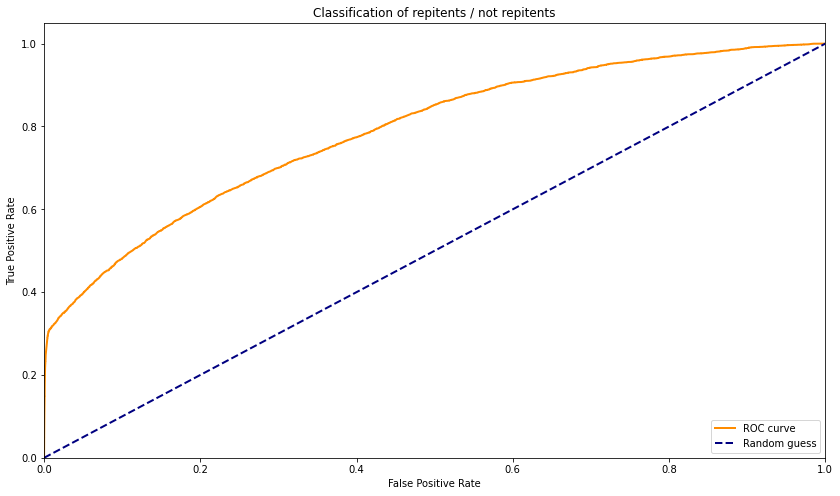

In [12]:
predict_p = model_res.predict(df_consolidado_frac[model_variables])
roc_p = roc_curve(df_consolidado_frac['REPITENTE'], predict_p)
plt.figure(figsize=(14,8))
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of repitents / not repitents')
plt.legend(loc='lower right')
plt.show()

In [13]:
repitens_frac_df = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 1].sample(n=10)
non_repitens_frac_df = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 0].sample(n=10)
predict_df = pd.concat([repitens_frac_df, non_repitens_frac_df])
# predict_df = pd.get_dummies(
#                                 predict_df,
#                                 columns=categorias,
#                                 prefix=categorias,
#                                 prefix_sep='_',
#                                 drop_first=True
#                                )
predict_df

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,SISBEN,FECHA_NACIMIENTO,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,CON_ALUM_ANIO_ANT,EDAD,NIVEL_SISBEN,INTERCEPTO,ESTRATO_1,ESTRATO_2,ESTRATO_3,ESTRATO_4,ESTRATO_5,ESTRATO_6,GENERO_M,POB_VICT_CONF_2,POB_VICT_CONF_3,POB_VICT_CONF_4,POB_VICT_CONF_6,POB_VICT_CONF_9,POB_VICT_CONF_10,POB_VICT_CONF_15,POB_VICT_CONF_17,POB_VICT_CONF_18,POB_VICT_CONF_99,CODIGO_ETNIA_1,CODIGO_ETNIA_2,CODIGO_ETNIA_3,CODIGO_ETNIA_4,CODIGO_ETNIA_5,CODIGO_ETNIA_6,CODIGO_ETNIA_8,CODIGO_ETNIA_9,CODIGO_ETNIA_10,CODIGO_ETNIA_12,CODIGO_ETNIA_14,CODIGO_ETNIA_15,CODIGO_ETNIA_16,CODIGO_ETNIA_17,CODIGO_ETNIA_19,CODIGO_ETNIA_20,CODIGO_ETNIA_22,CODIGO_ETNIA_23,CODIGO_ETNIA_25,CODIGO_ETNIA_26,CODIGO_ETNIA_27,CODIGO_ETNIA_28,CODIGO_ETNIA_29,CODIGO_ETNIA_31,CODIGO_ETNIA_33,CODIGO_ETNIA_34,CODIGO_ETNIA_35,CODIGO_ETNIA_36,CODIGO_ETNIA_40,CODIGO_ETNIA_42,CODIGO_ETNIA_43,CODIGO_ETNIA_45,CODIGO_ETNIA_46,CODIGO_ETNIA_47,CODIGO_ETNIA_48,CODIGO_ETNIA_49,CODIGO_ETNIA_50,CODIGO_ETNIA_51,CODIGO_ETNIA_54,CODIGO_ETNIA_57,CODIGO_ETNIA_58,CODIGO_ETNIA_64,CODIGO_ETNIA_65,CODIGO_ETNIA_66,CODIGO_ETNIA_67,CODIGO_ETNIA_72,CODIGO_ETNIA_73,CODIGO_ETNIA_74,CODIGO_ETNIA_75,CODIGO_ETNIA_77,CODIGO_ETNIA_82,CODIGO_ETNIA_83,CODIGO_ETNIA_85,CODIGO_ETNIA_86,CODIGO_ETNIA_95,CODIGO_ETNIA_96,CODIGO_ETNIA_97,CODIGO_ETNIA_98,CODIGO_ETNIA_99,CODIGO_ETNIA_101,CODIGO_ETNIA_102,CODIGO_ETNIA_107,CODIGO_ETNIA_200,CODIGO_ETNIA_400,CODIGO_ETNIA_998,CODIGO_ETNIA_999,CODIGO_JORNADA_2,CODIGO_JORNADA_3,CODIGO_JORNADA_4,CODIGO_JORNADA_5,CODIGO_JORNADA_6,CODIGO_METODOLOGIA_2,CODIGO_METODOLOGIA_9,CODIGO_METODOLOGIA_10,CODIGO_METODOLOGIA_11,CODIGO_METODOLOGIA_12,CODIGO_METODOLOGIA_20,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8,ZONA_RESI_ALU_2,NIVEL_2,NIVEL_3,NIVEL_4,DIR_NUM_LOCALIDAD_2,DIR_NUM_LOCALIDAD_3,DIR_NUM_LOCALIDAD_4,DIR_NUM_LOCALIDAD_5,DIR_NUM_LOCALIDAD_6,DIR_NUM_LOCALIDAD_7,DIR_NUM_LOCALIDAD_8,DIR_NUM_LOCALIDAD_9,DIR_NUM_LOCALIDAD_10,DIR_NUM_LOCALIDAD_11,DIR_NUM_LOCALIDAD_12,DIR_NUM_LOCALIDAD_13,DIR_NUM_LOCALIDAD_14,DIR_NUM_LOCALIDAD_15,DIR_NUM_LOCALIDAD_16,DIR_NUM_LOCALIDAD_17,DIR_NUM_LOCALIDAD_18,DIR_NUM_LOCALIDAD_19,DIR_NUM_LOCALIDAD_20
4232885,2021,111001104264,111001104264,2,1019063650,CL 130 159 A 05,11,1,0.000000,2009-05-25,N,N,99,9,0,0,4,1,9,12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3765655,2021,111001012271,111001012271,5,1111334171,DG 49 A SUR # 29 - 40,11,1,22.015625,2005-03-19,N,N,99,9,0,0,9,1,9,16,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2812650,2019,111001009971,111001009971,7,1120560862,CR 110 # 64 - 79,11,1,58.000000,2004-12-23,N,N,99,9,0,0,8,1,9,14,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1226818,2018,111001002330,111001002330,5,1031807853,CL 137 126 15,11,1,NaN,2006-07-28,N,N,99,9,0,0,6,1,9,11,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3770820,2021,111001012335,111001086576,5,1206217191,CL 49 SUR 12 B 38 ESTE,11,1,0.000000,2013-04-25,N,N,99,9,0,0,2,1,9,8,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [14]:
predict_p = model_res.predict(predict_df[model_variables])
predict_p.to_frame()
predict_df = predict_df.merge(predict_p.to_frame(), left_index=True, right_index=True)
predict_df[['REPITENTE', 0]]

,REPITENTE,0
4232885,1,0.656676
3765655,1,0.761392
2812650,1,0.025808
1226818,1,0.012554
3770820,1,0.619667
3391562,1,0.025428
172167,1,0.009945
4423087,1,0.674281
3744923,1,0.645135
3957096,1,0.567837


# Modelo Con Dataset Balanceado

In [140]:
df_repitentes = df_consolidado[df_consolidado['REPITENTE'] == 1]
df_no_repitentes = df_consolidado[df_consolidado['REPITENTE'] == 0].sample(n=df_repitentes.shape[0], random_state=145)
df_consolidado_frac = pd.concat([df_no_repitentes, df_repitentes])
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,SIT_ACAD_ANIO_ANT,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO
814434,2017,311001003378,311001003378,2,1014738144,NOREPORTA,11,1,3,NaN,2001-01-19,M,9,S,N,99,9,0,1,1,5,10,1,0,1,9,1,16,4,6,0,1
1003944,2017,311001065284,311001065284,7,1024505604,NOREPORTA,11,1,2,NaN,2008-06-07,F,9,S,N,99,9,0,1,0,0,4,1,0,1,9,1,8,2,11,0,1
3754824,2021,111001011771,111001024708,5,1016963442,CL 97 92 60,11,1,1,0.000000,2015-12-14,M,99,N,N,99,9,0,6,0,0,-1,1,0,0,9,1,5,1,10,1,1
121494,2017,111001012611,111001012611,7,1033692049,TR 17 B # 35 SUR - 39,11,1,2,22.703125,2005-10-25,M,9,N,N,99,9,0,3,0,0,6,1,0,1,9,1,11,3,18,1,1
352406,2017,111001036625,111001036625,5,1062396522,CL 10 12 15,23,182,1,NaN,2006-05-21,F,9,N,N,99,9,0,2,0,0,3,1,0,1,9,1,10,2,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463619,2021,311001075034,311001075034,5,1033787653,KR 25 76 23 SUR,11,1,0,0.000000,2014-04-16,F,99,N,N,99,9,0,2,0,0,1,1,1,2,9,1,7,2,19,1,1
4463652,2021,311001075034,311001075034,5,1028790096,KR 25 A 77 55 SUR,11,1,1,0.000000,2013-09-25,M,99,N,N,99,9,0,2,0,0,1,1,1,2,9,1,7,2,19,1,1
4463679,2021,311001075034,311001075034,8,N37664389692,MZ 5 LT 48,11,1,1,0.000000,2006-09-26,M,99,N,N,99,9,0,3,0,0,8,1,1,2,9,1,14,3,19,1,1
4463869,2021,311001097500,311001097500,1,1010010733,CL 138 B 152 41,11,1,2,39.156250,2000-09-01,M,99,N,N,8,9,0,6,1,5,10,1,1,2,9,1,20,4,11,1,1


In [141]:
# categorias = [
# #     'RES_DEPTO', # Muy grande
#     'ESTRATO',
#     'GENERO',
#     'POB_VICT_CONF',
#     'PROVIENE_SECTOR_PRIV',
#     'PROVIENE_OTR_MUN',
#     'TIPO_DISCAPACIDAD',
#     'CAP_EXC', # No hay correlacion
#     'CODIGO_ETNIA', # Muy largo
#     'CODIGO_JORNADA',
#     'CARACTER',
# #     'CODIGO_ESPECIALIDAD', # Parecido a CARACTER
# #     'CODIGO_GRADO',  # Parecido a NIVEL
#     'CODIGO_METODOLOGIA',
#     'SIT_ACAD_ANIO_ANT',
# #     'CON_ALUM_ANIO_ANT',  # Arroja un probelma enternando el modelo
#     'ZONA_RESI_ALU',
#     'NIVEL',
#     'DIR_NUM_LOCALIDAD',
#     'NIVEL_SISBEN'
# ]

categorias = [
#     'RES_DEPTO', # Muy grande
    'ESTRATO',
    'GENERO',
    'POB_VICT_CONF',
#     'PROVIENE_SECTOR_PRIV',
#     'PROVIENE_OTR_MUN',
#     'TIPO_DISCAPACIDAD',
#     'CAP_EXC', # No hay correlacion
#     'CODIGO_ETNIA', # Muy largo
    'CODIGO_JORNADA',
#     'CARACTER',
#     'CODIGO_ESPECIALIDAD', # Parecido a CARACTER
#     'CODIGO_GRADO',  # Parecido a NIVEL
    'CODIGO_METODOLOGIA',
    'SIT_ACAD_ANIO_ANT',
#     'CON_ALUM_ANIO_ANT',  # Arroja un probelma enternando el modelo
    'ZONA_RESI_ALU',
    'NIVEL',
    'DIR_NUM_LOCALIDAD',
#     'NIVEL_SISBEN'
]

In [142]:
df_consolidado_frac = pd.get_dummies(
                                df_consolidado_frac,
                                columns=categorias,
                                prefix=categorias,
                                prefix_sep='_',
                                drop_first=True
                               )
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,SISBEN,FECHA_NACIMIENTO,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,CON_ALUM_ANIO_ANT,EDAD,NIVEL_SISBEN,INTERCEPTO,ESTRATO_1,ESTRATO_2,ESTRATO_3,ESTRATO_4,ESTRATO_5,ESTRATO_6,GENERO_M,POB_VICT_CONF_2,POB_VICT_CONF_3,POB_VICT_CONF_4,POB_VICT_CONF_6,POB_VICT_CONF_7,POB_VICT_CONF_9,POB_VICT_CONF_10,POB_VICT_CONF_11,POB_VICT_CONF_13,POB_VICT_CONF_15,POB_VICT_CONF_16,POB_VICT_CONF_17,POB_VICT_CONF_18,POB_VICT_CONF_20,POB_VICT_CONF_99,CODIGO_JORNADA_2,CODIGO_JORNADA_3,CODIGO_JORNADA_4,CODIGO_JORNADA_5,CODIGO_JORNADA_6,CODIGO_METODOLOGIA_2,CODIGO_METODOLOGIA_9,CODIGO_METODOLOGIA_10,CODIGO_METODOLOGIA_11,CODIGO_METODOLOGIA_12,CODIGO_METODOLOGIA_20,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8,ZONA_RESI_ALU_2,NIVEL_2,NIVEL_3,NIVEL_4,DIR_NUM_LOCALIDAD_2,DIR_NUM_LOCALIDAD_3,DIR_NUM_LOCALIDAD_4,DIR_NUM_LOCALIDAD_5,DIR_NUM_LOCALIDAD_6,DIR_NUM_LOCALIDAD_7,DIR_NUM_LOCALIDAD_8,DIR_NUM_LOCALIDAD_9,DIR_NUM_LOCALIDAD_10,DIR_NUM_LOCALIDAD_11,DIR_NUM_LOCALIDAD_12,DIR_NUM_LOCALIDAD_13,DIR_NUM_LOCALIDAD_14,DIR_NUM_LOCALIDAD_15,DIR_NUM_LOCALIDAD_16,DIR_NUM_LOCALIDAD_17,DIR_NUM_LOCALIDAD_18,DIR_NUM_LOCALIDAD_19,DIR_NUM_LOCALIDAD_20
814434,2017,311001003378,311001003378,2,1014738144,NOREPORTA,11,1,NaN,2001-01-19,S,N,99,9,0,1,5,10,0,9,16,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1003944,2017,311001065284,311001065284,7,1024505604,NOREPORTA,11,1,NaN,2008-06-07,S,N,99,9,0,0,0,4,0,9,8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3754824,2021,111001011771,111001024708,5,1016963442,CL 97 92 60,11,1,0.000000,2015-12-14,N,N,99,9,0,0,0,-1,0,9,5,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
121494,2017,111001012611,111001012611,7,1033692049,TR 17 B # 35 SUR - 39,11,1,22.703125,2005-10-25,N,N,99,9,0,0,0,6,0,9,11,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
352406,2017,111001036625,111001036625,5,1062396522,CL 10 12 15,23,182,NaN,2006-05-21,N,N,99,9,0,0,0,3,0,9,10,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463619,2021,311001075034,311001075034,5,1033787653,KR 25 76 23 SUR,11,1,0.000000,2014-04-16,N,N,99,9,0,0,0,1,1,9,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4463652,2021,311001075034,311001075034,5,1028790096,KR 25 A 77 55 SUR,11,1,0.000000,2013-09-25,N,N,99,9,0,0,0,1,1,9,7,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4463679,2021,311001075034,311001075034,8,N37664389692,MZ 5 LT 48,11,1,0.000000,2006-09-26,N,N,99,9,0,0,0,8,1,9,14,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4463869,2021,311001097500,311001097500,1,1010010733,CL 138 B 152 41,11,1,39.156250,2000-09-01,N,N,8,9,0,1,5,10,1,9,20,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [143]:
# df_consolidado_frac.columns[15:].tolist()

In [144]:
# model_variables = df_consolidado_frac.columns[14:].tolist()
model_variables = df_consolidado_frac.columns[21:].tolist()
intercepto_idx = model_variables.index('INTERCEPTO')
model_variables_first = model_variables[0]
model_variables[intercepto_idx] = model_variables_first
model_variables[0] = 'INTERCEPTO'
# model_variables = model_variables[:model_variables.index('NIVEL_SISBEN_1')]
model_variables.append('EDAD')
model_variables

['INTERCEPTO',
 'NIVEL_SISBEN',
 'ESTRATO_1',
 'ESTRATO_2',
 'ESTRATO_3',
 'ESTRATO_4',
 'ESTRATO_5',
 'ESTRATO_6',
 'GENERO_M',
 'POB_VICT_CONF_2',
 'POB_VICT_CONF_3',
 'POB_VICT_CONF_4',
 'POB_VICT_CONF_6',
 'POB_VICT_CONF_7',
 'POB_VICT_CONF_9',
 'POB_VICT_CONF_10',
 'POB_VICT_CONF_11',
 'POB_VICT_CONF_13',
 'POB_VICT_CONF_15',
 'POB_VICT_CONF_16',
 'POB_VICT_CONF_17',
 'POB_VICT_CONF_18',
 'POB_VICT_CONF_20',
 'POB_VICT_CONF_99',
 'CODIGO_JORNADA_2',
 'CODIGO_JORNADA_3',
 'CODIGO_JORNADA_4',
 'CODIGO_JORNADA_5',
 'CODIGO_JORNADA_6',
 'CODIGO_METODOLOGIA_2',
 'CODIGO_METODOLOGIA_9',
 'CODIGO_METODOLOGIA_10',
 'CODIGO_METODOLOGIA_11',
 'CODIGO_METODOLOGIA_12',
 'CODIGO_METODOLOGIA_20',
 'SIT_ACAD_ANIO_ANT_1',
 'SIT_ACAD_ANIO_ANT_2',
 'SIT_ACAD_ANIO_ANT_8',
 'ZONA_RESI_ALU_2',
 'NIVEL_2',
 'NIVEL_3',
 'NIVEL_4',
 'DIR_NUM_LOCALIDAD_2',
 'DIR_NUM_LOCALIDAD_3',
 'DIR_NUM_LOCALIDAD_4',
 'DIR_NUM_LOCALIDAD_5',
 'DIR_NUM_LOCALIDAD_6',
 'DIR_NUM_LOCALIDAD_7',
 'DIR_NUM_LOCALIDAD_8',
 'DIR_N

In [34]:
np.log(0.03)

-3.506557897319982

In [145]:
model = sm.GLM(df_consolidado_frac['REPITENTE'], df_consolidado_frac[model_variables], family=sm.families.Binomial())

model_res = model.fit()

model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              REPITENTE   No. Observations:               218696
Model:                            GLM   Df Residuals:                   218634
Model Family:                Binomial   Df Model:                           61
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1627e+05
Date:                Tue, 21 Jun 2022   Deviance:                   2.3254e+05
Time:                        22:59:37   Pearson chi2:                 2.17e+05
No. Iterations:                    22   Pseudo R-squ. (CS):             0.2760
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
INTERCEPTO               -3.6636      0.075    -48.701      0.000      -3.811      -3.516
NIVEL_SISBEN             -0.0346      0.006     -5.923      0.000      -0.046      -0.023
ESTRATO_1                -0.0487      0.020     -2.428      0.015      -0.088      -0.009
ESTRATO_2                -0.0873      0.018     -4.929      0.000      -0.122      -0.053
ESTRATO_3                -0.2624      0.021    -12.345      0.000      -0.304      -0.221
ESTRATO_4                -0.4893      0.059     -8.348      0.000      -0.604      -0.374
ESTRATO_5                -0.5523      0.123     -4.480      0.000      -0.794      -0.311
ESTRATO_6                -1.1375      0.187     -6.088      0.000      -1.504      -0.771
GENERO_M                  0.2409      0.010     23.951      0.000       0.221       0.261
POB_VICT_CONF_2          -0.3909      0.284     -1.375      0.169      -0.948       0.166
POB_VICT_CONF_3          -0.1982      0.221     -0.896      0.370      -0.632       0.235
POB_VICT_CONF_4          -0.2622      0.371     -0.706      0.480      -0.990       0.465
POB_VICT_CONF_6          20.3626   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
POB_VICT_CONF_7          -1.4352      1.337     -1.073      0.283      -4.056       1.186
POB_VICT_CONF_9          -0.5451      0.028    -19.576      0.000      -0.600      -0.491
POB_VICT_CONF_10         -0.1233      0.202     -0.609      0.542      -0.520       0.273
POB_VICT_CONF_11        -23.3755   5.61e+04     -0.000      1.000    -1.1e+05     1.1e+05
POB_VICT_CONF_13         19.8222   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
POB_VICT_CONF_15        -20.7661   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
POB_VICT_CONF_16        -23.6399   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
POB_VICT_CONF_17         -2.4222      1.383     -1.752      0.080      -5.132       0.288
POB_VICT_CONF_18         -1.3982      0.685     -2.040      0.041      -2.741      -0.055
POB_VICT_CONF_20        -23.4797   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
POB_VICT_CONF_99          0.1256      0.027      4.657      0.000       0.073       0.179
CODIGO_JORNADA_2          0.5863      0.023     24.991      0.000       0.540       0.632
CODIGO_JORNADA_3          0.5804      0.024     24.425      0.000       0.534       0.627
CODIGO_JORNADA_4          0.6202      0.250      2.482      0.013       0.130       1.110
CODIGO_JORNADA_5         -1.0685      0.292     -3.659      0.000      -1.641      -0.496
CODIGO_JORNADA_6          0.2792      0.027     10.376      0.000       0.227       0.332
CODIGO_METODOLOGIA_2    -21.9875   2.38e+04     -0.001      0.999   -4.66e+04    4.66e+04
CODIGO_METODOLOGIA_9     -0.2515      0.049     -5.083      0.000      -0.348      -0.155
CODIGO_METODOLOGIA_10  

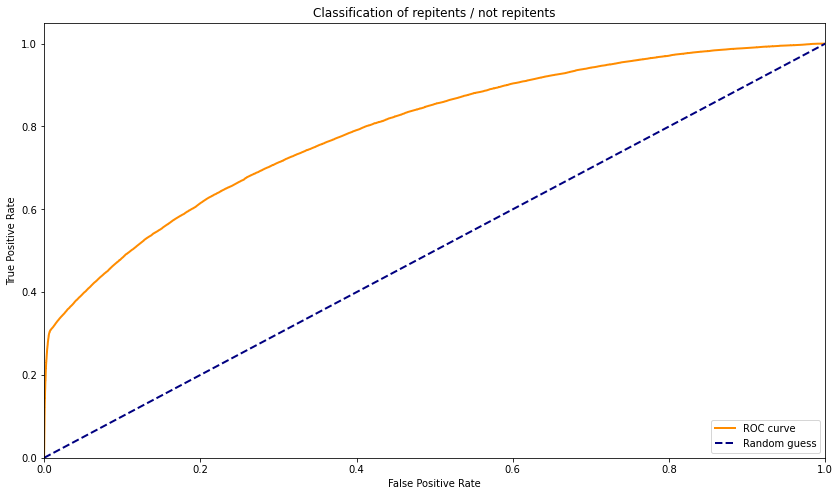

In [146]:
predict_p = model_res.predict(df_consolidado_frac[model_variables])
roc_p = roc_curve(df_consolidado_frac['REPITENTE'], predict_p)
plt.figure(figsize=(14,8))
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of repitents / not repitents')
plt.legend(loc='lower right')
plt.show()

In [147]:
repitens_frac_df = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 1].sample(n=5)
non_repitens_frac_df = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 0].sample(n=5)
predict_df = pd.concat([repitens_frac_df, non_repitens_frac_df])
# predict_df = pd.get_dummies(
#                                 predict_df,
#                                 columns=categorias,
#                                 prefix=categorias,
#                                 prefix_sep='_',
#                                 drop_first=True
#                                )
predict_df

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,SISBEN,FECHA_NACIMIENTO,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,CON_ALUM_ANIO_ANT,EDAD,NIVEL_SISBEN,INTERCEPTO,ESTRATO_1,ESTRATO_2,ESTRATO_3,ESTRATO_4,ESTRATO_5,ESTRATO_6,GENERO_M,POB_VICT_CONF_2,POB_VICT_CONF_3,POB_VICT_CONF_4,POB_VICT_CONF_6,POB_VICT_CONF_7,POB_VICT_CONF_9,POB_VICT_CONF_10,POB_VICT_CONF_11,POB_VICT_CONF_13,POB_VICT_CONF_15,POB_VICT_CONF_16,POB_VICT_CONF_17,POB_VICT_CONF_18,POB_VICT_CONF_20,POB_VICT_CONF_99,CODIGO_JORNADA_2,CODIGO_JORNADA_3,CODIGO_JORNADA_4,CODIGO_JORNADA_5,CODIGO_JORNADA_6,CODIGO_METODOLOGIA_2,CODIGO_METODOLOGIA_9,CODIGO_METODOLOGIA_10,CODIGO_METODOLOGIA_11,CODIGO_METODOLOGIA_12,CODIGO_METODOLOGIA_20,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8,ZONA_RESI_ALU_2,NIVEL_2,NIVEL_3,NIVEL_4,DIR_NUM_LOCALIDAD_2,DIR_NUM_LOCALIDAD_3,DIR_NUM_LOCALIDAD_4,DIR_NUM_LOCALIDAD_5,DIR_NUM_LOCALIDAD_6,DIR_NUM_LOCALIDAD_7,DIR_NUM_LOCALIDAD_8,DIR_NUM_LOCALIDAD_9,DIR_NUM_LOCALIDAD_10,DIR_NUM_LOCALIDAD_11,DIR_NUM_LOCALIDAD_12,DIR_NUM_LOCALIDAD_13,DIR_NUM_LOCALIDAD_14,DIR_NUM_LOCALIDAD_15,DIR_NUM_LOCALIDAD_16,DIR_NUM_LOCALIDAD_17,DIR_NUM_LOCALIDAD_18,DIR_NUM_LOCALIDAD_19,DIR_NUM_LOCALIDAD_20
2300637,2019,111001102067,111001086371,5,1206216973,KR 7 ESTE 0 06,11,1,NaN,2013-03-23,N,N,99,9,0,0,0,0,1,9,6,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2181903,2018,311001043248,311001043248,5,1023388786,CL 71 SUR 47 B 11,11,1,NaN,2010-04-27,N,N,99,9,0,0,0,1,1,5,7,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3273326,2020,111001036561,111001036561,5,1028784240,KR 18 78 21 SUR,11,1,NaN,2007-02-18,N,N,99,9,0,0,0,6,1,9,13,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1301037,2018,111001012343,111001012343,2,1097990463,KR 90 D 40 A 16 SUR,68,190,NaN,2004-08-11,N,N,99,9,0,0,0,7,1,9,13,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3346047,2020,111001077895,111001077895,5,1000226089,KR 2 A ESTE 90 A 57 SUR,11,1,24.000000,2002-10-02,N,N,99,9,0,1,5,10,1,9,17,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
530513,2017,111001102083,111001047236,5,1014993773,KR 71 G 12 82,11,1,NaN,2010-05-17,N,N,99,9,0,0,0,2,0,9,6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3331719,2020,111001075957,111001018066,2,1033698581,CL 57 13 F 20 SUR,11,1,0.010002,2006-07-11,S,N,99,9,0,0,0,8,0,9,13,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
758498,2017,211850000051,211850000051,5,1140917844,KR 10 82 44 SUR,11,1,4.531250,2008-01-09,N,N,99,9,0,0,0,4,0,9,9,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3563253,2020,111102000753,111102000753,2,1066872897,KR 87 H 65 18 SUR,11,1,0.000000,2007-09-25,N,N,99,9,0,0,0,6,0,9,12,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
711381,2017,111769003424,111769003424,2,1001114331,CL 127 94 79,11,1,49.406250,2001-09-06,N,N,99,9,0,1,5,10,0,9,15,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [148]:
predict_p = model_res.predict(predict_df[model_variables])
predict_p.to_frame()
predict_df = predict_df.merge(predict_p.to_frame(), left_index=True, right_index=True)
predict_df[['REPITENTE', 0]]

,REPITENTE,0
2300637,1,0.378376
2181903,1,0.168244
3273326,1,0.561793
1301037,1,0.311483
3346047,1,0.428140
530513,0,0.158208
3331719,0,0.580915
758498,0,0.311241
3563253,0,0.604222
711381,0,0.184729


In [149]:
df_consolidado_frac[df_consolidado_frac.index.isin(predict_df.index)].sort_index()

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,SISBEN,FECHA_NACIMIENTO,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,CON_ALUM_ANIO_ANT,EDAD,NIVEL_SISBEN,INTERCEPTO,ESTRATO_1,ESTRATO_2,ESTRATO_3,ESTRATO_4,ESTRATO_5,ESTRATO_6,GENERO_M,POB_VICT_CONF_2,POB_VICT_CONF_3,POB_VICT_CONF_4,POB_VICT_CONF_6,POB_VICT_CONF_7,POB_VICT_CONF_9,POB_VICT_CONF_10,POB_VICT_CONF_11,POB_VICT_CONF_13,POB_VICT_CONF_15,POB_VICT_CONF_16,POB_VICT_CONF_17,POB_VICT_CONF_18,POB_VICT_CONF_20,POB_VICT_CONF_99,CODIGO_JORNADA_2,CODIGO_JORNADA_3,CODIGO_JORNADA_4,CODIGO_JORNADA_5,CODIGO_JORNADA_6,CODIGO_METODOLOGIA_2,CODIGO_METODOLOGIA_9,CODIGO_METODOLOGIA_10,CODIGO_METODOLOGIA_11,CODIGO_METODOLOGIA_12,CODIGO_METODOLOGIA_20,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8,ZONA_RESI_ALU_2,NIVEL_2,NIVEL_3,NIVEL_4,DIR_NUM_LOCALIDAD_2,DIR_NUM_LOCALIDAD_3,DIR_NUM_LOCALIDAD_4,DIR_NUM_LOCALIDAD_5,DIR_NUM_LOCALIDAD_6,DIR_NUM_LOCALIDAD_7,DIR_NUM_LOCALIDAD_8,DIR_NUM_LOCALIDAD_9,DIR_NUM_LOCALIDAD_10,DIR_NUM_LOCALIDAD_11,DIR_NUM_LOCALIDAD_12,DIR_NUM_LOCALIDAD_13,DIR_NUM_LOCALIDAD_14,DIR_NUM_LOCALIDAD_15,DIR_NUM_LOCALIDAD_16,DIR_NUM_LOCALIDAD_17,DIR_NUM_LOCALIDAD_18,DIR_NUM_LOCALIDAD_19,DIR_NUM_LOCALIDAD_20
530513,2017,111001102083,111001047236,5,1014993773,KR 71 G 12 82,11,1,NaN,2010-05-17,N,N,99,9,0,0,0,2,0,9,6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
711381,2017,111769003424,111769003424,2,1001114331,CL 127 94 79,11,1,49.406250,2001-09-06,N,N,99,9,0,1,5,10,0,9,15,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
758498,2017,211850000051,211850000051,5,1140917844,KR 10 82 44 SUR,11,1,4.531250,2008-01-09,N,N,99,9,0,0,0,4,0,9,9,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1301037,2018,111001012343,111001012343,2,1097990463,KR 90 D 40 A 16 SUR,68,190,NaN,2004-08-11,N,N,99,9,0,0,0,7,1,9,13,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2181903,2018,311001043248,311001043248,5,1023388786,CL 71 SUR 47 B 11,11,1,NaN,2010-04-27,N,N,99,9,0,0,0,1,1,5,7,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2300637,2019,111001102067,111001086371,5,1206216973,KR 7 ESTE 0 06,11,1,NaN,2013-03-23,N,N,99,9,0,0,0,0,1,9,6,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3273326,2020,111001036561,111001036561,5,1028784240,KR 18 78 21 SUR,11,1,NaN,2007-02-18,N,N,99,9,0,0,0,6,1,9,13,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3331719,2020,111001075957,111001018066,2,1033698581,CL 57 13 F 20 SUR,11,1,0.010002,2006-07-11,S,N,99,9,0,0,0,8,0,9,13,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3346047,2020,111001077895,111001077895,5,1000226089,KR 2 A ESTE 90 A 57 SUR,11,1,24.000000,2002-10-02,N,N,99,9,0,1,5,10,1,9,17,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3563253,2020,111102000753,111102000753,2,1066872897,KR 87 H 65 18 SUR,11,1,0.000000,2007-09-25,N,N,99,9,0,0,0,6,0,9,12,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modelo Solo Info Academica

In [16]:
years = df_consolidado['ANO_INF'].unique().tolist()
options = df_consolidado['REPITENTE'].unique().tolist()

seed = 145
fractions= []
for year in years:
    fraction = df_consolidado[df_consolidado['ANO_INF'] == year]
    n_frac = math.ceil((fraction.shape[0] / df_consolidado.shape[0]) * n)
    n_frac = int(n_frac)
#     print(n_frac)
    fraction = fraction.sample(n=n_frac, random_state=seed)
    fractions.append(fraction)

df_consolidado_frac = pd.concat(fractions)
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,SIT_ACAD_ANIO_ANT,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,0,21.921875,2011-08-05,M,9,N,N,99,9,0,2,0,0,0,1,0,1,9,1,5,1,18,1,1
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,3,0.010002,2002-07-05,M,9,N,N,99,9,0,3,0,0,9,1,0,1,9,1,14,3,11,1,1
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,3,NaN,2009-08-27,M,9,N,N,99,9,0,2,0,0,2,1,0,8,8,1,7,2,6,0,1
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,3,NaN,2008-05-16,F,9,N,N,99,9,0,1,0,0,4,1,0,1,9,1,8,2,15,0,1
71847,2017,111001011011,111001011011,2,1122839699,CL 48 SUR 29 80,11,1,2,25.890625,2006-02-10,M,9,N,N,99,9,0,2,0,0,6,1,0,1,9,1,11,3,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940622,2021,111001025313,111001025313,5,1010215877,KR 19 A 12 45,11,1,2,0.000000,2012-05-28,F,99,S,N,99,9,0,6,0,0,3,1,0,1,9,1,9,2,14,1,1
3743164,2021,111001011053,111001011053,2,1013590836,KR 23 A 16 14 SUR,11,1,3,13.531250,2005-09-02,M,99,N,N,99,9,0,2,0,0,9,1,1,2,9,1,15,3,15,1,1
3959866,2021,111001027391,111001027391,5,1028898686,KR 93 C 61 B 67 SUR,11,1,2,0.000000,2016-10-02,F,99,N,N,99,9,0,3,0,0,-1,1,0,1,9,1,4,1,8,1,1
4082831,2021,111001075329,111001075329,5,1023404127,KR 18 ESTE 60 A 11 SUR,25,754,1,0.000000,2014-08-12,M,99,N,N,99,9,0,2,0,0,1,1,0,1,9,1,6,2,19,1,1


In [17]:
years = df_consolidado['ANO_INF'].unique().tolist()
per_original = df_consolidado[df_consolidado['REPITENTE'] == 1].shape[0] / df_consolidado.shape[0]
per_fraction = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 1].shape[0] / df_consolidado_frac.shape[0]
print(f'original: {per_original} - fraction: {per_fraction} ==> error: {per_original - per_fraction}')
for year in years:
    per_original = df_consolidado[(df_consolidado['ANO_INF'] == year) & (df_consolidado['REPITENTE'] == 1)].shape[0] / df_consolidado[df_consolidado['ANO_INF'] == year].shape[0]  
    per_fraction = df_consolidado_frac[(df_consolidado_frac['ANO_INF'] == year) & (df_consolidado_frac['REPITENTE'] == 1)].shape[0] / df_consolidado_frac[df_consolidado_frac['ANO_INF'] == year].shape[0] 
    print(f'original {year} : {per_original} - fraction {year}: {per_fraction} ==> error: {per_original - per_fraction}')

original: 0.02489124251570271 - fraction: 0.024816537163487952 ==> error: 7.470535221475866e-05
original 2017 : 0.008464341488807913 - fraction 2017: 0.008787510516967374 ==> error: -0.00032316902815946076
original 2018 : 0.01433381376903274 - fraction 2018: 0.014443858724301529 ==> error: -0.00011004495526878953
original 2019 : 0.03739717332957218 - fraction 2019: 0.036681665127089605 ==> error: 0.000715508202482576
original 2020 : 0.03911085777791781 - fraction 2020: 0.039596321214739834 ==> error: -0.0004854634368220215
original 2021 : 0.03837954964348135 - fraction 2021: 0.03758280383939435 ==> error: 0.0007967458040869999


In [18]:
categorias = [
#     'RES_DEPTO', # Muy grande
#     'ESTRATO',
#     'GENERO',
#     'POB_VICT_CONF',
#     'PROVIENE_SECTOR_PRIV',
#     'PROVIENE_OTR_MUN',
#     'TIPO_DISCAPACIDAD',
#     'CAP_EXC', # No hay correlacion
#     'CODIGO_ETNIA', # Muy largo
#     'CODIGO_JORNADA',
#     'CARACTER',
#     'CODIGO_ESPECIALIDAD', # Parecido a CARACTER
#     'CODIGO_GRADO',  # Parecido a NIVEL
#     'CODIGO_METODOLOGIA',
    'SIT_ACAD_ANIO_ANT',
#     'CON_ALUM_ANIO_ANT',  # Arroja un probelma enternando el modelo
#     'ZONA_RESI_ALU',
#     'NIVEL',
#     'DIR_NUM_LOCALIDAD',
#     'NIVEL_SISBEN'
]

In [19]:
df_consolidado_frac = pd.get_dummies(
                                df_consolidado_frac,
                                columns=categorias,
                                prefix=categorias,
                                prefix_sep='_',
                                drop_first=True
                               )
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,0,21.921875,2011-08-05,M,9,N,N,99,9,0,2,0,0,0,1,0,9,1,5,1,18,1,1,1,0,0
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,3,0.010002,2002-07-05,M,9,N,N,99,9,0,3,0,0,9,1,0,9,1,14,3,11,1,1,1,0,0
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,3,NaN,2009-08-27,M,9,N,N,99,9,0,2,0,0,2,1,0,8,1,7,2,6,0,1,0,0,1
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,3,NaN,2008-05-16,F,9,N,N,99,9,0,1,0,0,4,1,0,9,1,8,2,15,0,1,1,0,0
71847,2017,111001011011,111001011011,2,1122839699,CL 48 SUR 29 80,11,1,2,25.890625,2006-02-10,M,9,N,N,99,9,0,2,0,0,6,1,0,9,1,11,3,6,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940622,2021,111001025313,111001025313,5,1010215877,KR 19 A 12 45,11,1,2,0.000000,2012-05-28,F,99,S,N,99,9,0,6,0,0,3,1,0,9,1,9,2,14,1,1,1,0,0
3743164,2021,111001011053,111001011053,2,1013590836,KR 23 A 16 14 SUR,11,1,3,13.531250,2005-09-02,M,99,N,N,99,9,0,2,0,0,9,1,1,9,1,15,3,15,1,1,0,1,0
3959866,2021,111001027391,111001027391,5,1028898686,KR 93 C 61 B 67 SUR,11,1,2,0.000000,2016-10-02,F,99,N,N,99,9,0,3,0,0,-1,1,0,9,1,4,1,8,1,1,1,0,0
4082831,2021,111001075329,111001075329,5,1023404127,KR 18 ESTE 60 A 11 SUR,25,754,1,0.000000,2014-08-12,M,99,N,N,99,9,0,2,0,0,1,1,0,9,1,6,2,19,1,1,1,0,0


In [9]:
# df_consolidado_frac.columns[15:].tolist()

In [22]:
model_variables = df_consolidado_frac.columns[21:].tolist()
intercepto_idx = model_variables.index('INTERCEPTO')
model_variables_first = model_variables[0]
model_variables[intercepto_idx] = model_variables_first
model_variables[0] = 'INTERCEPTO'
# model_variables = model_variables[:model_variables.index('NIVEL_SISBEN_1')]
model_variables.append('EDAD')
model_variables = [
    'INTERCEPTO',
    'SIT_ACAD_ANIO_ANT_1',
    'SIT_ACAD_ANIO_ANT_2',
    'SIT_ACAD_ANIO_ANT_8'
]
model_variables

['INTERCEPTO',
 'SIT_ACAD_ANIO_ANT_1',
 'SIT_ACAD_ANIO_ANT_2',
 'SIT_ACAD_ANIO_ANT_8']

In [23]:
model = sm.GLM(df_consolidado_frac['REPITENTE'], df_consolidado_frac[model_variables], family=sm.families.Binomial())
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              REPITENTE   No. Observations:               203856
Model:                            GLM   Df Residuals:                   203852
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19618.
Date:                Wed, 22 Jun 2022   Deviance:                       39235.
Time:                        02:06:54   Pearson chi2:                 2.04e+05
No. Iterations:                     9   Pseudo R-squ. (CS):            0.03921
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
INTERCEPTO             -6.0293      0.230    -26.250      0.000      -6.479      -5.579
SIT_ACAD_ANIO_ANT_1     2.0424      0.230      8.867      0.000       1.591       2.494
SIT_ACAD_ANIO_ANT_2     6.0987      0.233     26.225      0.000       5.643       6.554
SIT_ACAD_ANIO_ANT_8     1.5030      0.265      5.673      0.000       0.984       2.022
=======================================================================================
"""

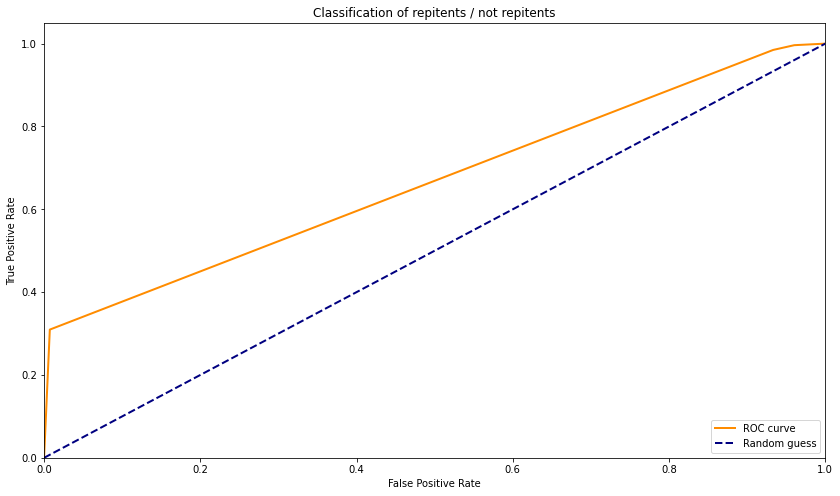

In [24]:
predict_p = model_res.predict(df_consolidado_frac[model_variables])
roc_p = roc_curve(df_consolidado_frac['REPITENTE'], predict_p)
plt.figure(figsize=(14,8))
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of repitents / not repitents')
plt.legend(loc='lower right')
plt.show()

In [25]:
repitens_frac_df = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 1].sample(n=10)
non_repitens_frac_df = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 0].sample(n=10)
predict_df = pd.concat([repitens_frac_df, non_repitens_frac_df])
# predict_df = pd.get_dummies(
#                                 predict_df,
#                                 columns=categorias,
#                                 prefix=categorias,
#                                 prefix_sep='_',
#                                 drop_first=True
#                                )
predict_df

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8
2599355,2019,111001018252,111001018252,7,1016592855,CR 1 C # 41 A SUR - 60,11,1,2,43.000000,2004-05-13,F,99,N,N,99,9,0,3,0,0,7,1,1,9,1,14,3,4,1,1,1,0,0
2554830,2019,111279000168,111279000168,7,1000253733,CL 22 H # 111 A - 46,11,1,3,0.010002,2002-09-11,M,99,N,N,99,9,0,2,0,0,9,1,1,9,1,16,3,9,1,1,1,0,0
2703080,2019,111001010731,111001010731,2,1021396988,CL 96 5 30 ESTE,11,1,2,51.000000,2006-08-07,M,99,N,N,99,9,0,6,0,0,6,1,1,9,1,12,3,13,2,1,1,0,0
3883994,2021,111001016136,111001016136,2,1013116143,KR 72 P 42 B 18 SUR,11,1,2,0.000000,2007-04-30,M,99,N,N,99,9,0,2,0,0,7,1,1,9,1,14,3,8,1,1,1,0,0
1874274,2018,111102000265,111102000265,5,1074527757,CL 65 H SUR # 77 - 41,11,1,1,55.000000,2009-02-07,M,9,N,N,99,9,0,3,0,0,4,1,1,9,1,9,2,7,3,1,1,0,0
1524724,2018,111001030015,111001030015,5,1012922135,CL 38 8 14 SUR,11,1,2,NaN,2011-07-26,F,9,S,N,99,9,0,3,0,0,1,1,1,9,1,6,2,18,0,1,1,0,0
1336758,2018,111001102067,111001013242,2,1116203894,VEREDA SAN JORGE,73,675,1,0.000000,2004-10-15,M,1,N,N,99,9,0,3,0,0,6,1,1,9,2,13,3,3,1,1,1,0,0
3442518,2020,111001102148,111001013323,2,1033702173,DG 81 A 45 B 20 SUR,11,1,1,24.000000,2006-10-21,M,99,N,N,99,9,0,2,0,0,6,1,1,9,1,13,3,17,1,1,1,0,0
2687814,2019,111102000265,111102000265,5,1012428446,KR 78 64 06,11,1,1,NaN,2010-04-08,F,99,N,N,99,9,0,2,0,0,3,1,1,9,1,8,2,7,0,1,1,0,0
3510202,2020,111001107794,111001107794,5,1000004059,KR 8 14 I 44 SUR,11,1,2,0.010002,2003-01-28,F,99,N,N,99,9,0,6,1,5,10,1,1,9,1,17,4,18,1,1,1,0,0


In [26]:
predict_p = model_res.predict(predict_df[model_variables])
predict_p.to_frame()
predict_df = predict_df.merge(predict_p.to_frame(), left_index=True, right_index=True)
predict_df[['REPITENTE', 0]]

,REPITENTE,0
2599355,1,0.018219
2554830,1,0.018219
2703080,1,0.018219
3883994,1,0.018219
1874274,1,0.018219
1524724,1,0.018219
1336758,1,0.018219
3442518,1,0.018219
2687814,1,0.018219
3510202,1,0.018219
